# Target Allocation Score (TAS)


#### Imports and setup

In [52]:
from typing import List
from random import randint

import lxml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from bs4 import BeautifulSoup
from IPython.display import Markdown as md
from IPython.display import Math
 
# configs 
plt.rcParams["figure.figsize"] = [16,9]
plt.rcParams["figure.autolayout"] = True
plt.style.use('seaborn-v0_8-darkgrid')

### getting Stats from liquipedia 

I curled the stats from `https://liquipedia.net/starcraft2/Unit_Statistics_(Legacy_of_the_Void)` in to `data/stats.html`. the unit stats are in a table with the class: `wikitable wikitable-bordered wikitable-striped`


#### Table Structure:

|Name|Supply|Mineral Cost|Vespene Cost|Build_time|Size|Cargo Size|Amour|Health|Shield|Attributes|Speed|Sight|Attack Name|Ground Attack|Air Attack|Bonus|Ground DPS|Air DPS|Bonus DPS|Cooldown|Range|
|---|---|---|---|---|---|---|---|----|---|---|---|---|---|----|---|---|---|---|---|---|---|
|String|Integer|Integer|Integer|Integer|String|Integer|Integer|Integer|Integer|String|Integer|String|String|Integer|Integer|String|Float|Float|Float|Float|Integer|


The Datatypes in the Table are not 'clean', so there have to be cleaned before they can be used. Based on this Table the UnitClass in this Notebook will be:

In [53]:
stats_file:str = 'data/stats.html'
headers:List[str] = ["Race","Name","Supply", "Mineral Cost",
           "Vespene Cost","Build_time","Size", 
           "Cargo Size", "Amour", "Health", "Shield", 
           "Attributes","Speed", "Sight", "Attack Name", 
           "Ground Attack", "Air Attack" ,"Bonus",
           "Ground DPS","Air DPS" ,"Bonus DPS" ,"Cooldown", "Range"]
temp:list = []

with open(stats_file, 'r', encoding='utf-8') as f:
     html_content = f.read()

soup = BeautifulSoup(html_content)
tables = soup.find_all('table', class_='wikitable')


races = {
     0: "Protoss", 
     1: "Terran", 
     2: "Zerg"
}

for i, table in enumerate(tables):
     print(i)
     rows = table.find_all('tr')
     for row in rows:
          cells = row.find_all(['td']) 
          row_data = [cell.get_text(strip=True) for cell in cells]
          if len(row_data) < 10:
               continue
          if len(row_data) < 22:
               row_data.insert(9, None)
          row_data.insert(0, races.get(i))
          temp.append(row_data)

df = pd.DataFrame(temp, columns=headers)
df.info()

0
1
2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Race           63 non-null     object
 1   Name           63 non-null     object
 2   Supply         63 non-null     object
 3   Mineral Cost   63 non-null     object
 4   Vespene Cost   63 non-null     object
 5   Build_time     63 non-null     object
 6   Size           63 non-null     object
 7   Cargo Size     63 non-null     object
 8   Amour          63 non-null     object
 9   Health         63 non-null     object
 10  Shield         20 non-null     object
 11  Attributes     63 non-null     object
 12  Speed          63 non-null     object
 13  Sight          63 non-null     object
 14  Attack Name    63 non-null     object
 15  Ground Attack  63 non-null     object
 16  Air Attack     63 non-null     object
 17  Bonus          63 non-null     object
 18  Ground DPS     63 non-null

In [54]:
df['Ground Splash'] = df["Ground Attack"].str.contains("Splash")
df['Air Splash'] = df["Air Attack"].str.contains("Splash")

df.loc[df["Mineral Cost"] == "varies", 'Mineral Cost'] = 175
df.loc[df["Vespene Cost"] == "varies", 'Vespene Cost'] = 275

rows:list = ['Amour','Health','Sight', 'Ground Attack', 
             'Air Attack', 'Ground DPS', 'Air DPS', 
             'Range', 'Cooldown']
for row in rows:
    df[row] = df[row].apply(lambda x: x.split('(')[0] if '(' in x else x)

df.head()

,Race,Name,Supply,Mineral Cost,Vespene Cost,Build_time,Size,Cargo Size,Amour,Health,...,Ground Attack,Air Attack,Bonus,Ground DPS,Air DPS,Bonus DPS,Cooldown,Range,Ground Splash,Air Splash
0,Protoss,Adept,2,100,25,30,-,2,1,70,...,10,-,+12 (+1) vsLight,6.2,-,+7.45 (+0.62) vsLight+10.81 (+0.9)Resonating G...,1.61,4,False,False
1,Protoss,Archon,4,175,275,8.57,-,4,0,10,...,25,25,+10 (+1) vsBiological,20,20,+8 (+0.8) vsBiological,1.25,3,True,True
2,Protoss,Carrier,6,350,250,64,Large,-,2,300,...,5,5,-,37.4,37.4,-,2.14,-,False,False
3,Protoss,Colossus,6,300,200,54,-,8,1,250,...,10,-,+5 (+1) vsLight,18.7,-,+9.3 (+1.87) vsLight,1.07,7,False,False
4,Protoss,Dark Templar,2,125,125,39,-,2,1,40,...,45,-,-,37.2,-,-,1.21,0.1,False,False


In [55]:
rows:list = ['Amour','Supply','Health','Sight', 'Ground Attack', 
             'Air Attack', 'Ground DPS', 'Air DPS', 'Range', 
             'Mineral Cost', 'Vespene Cost']
for row in rows:
    df[row] = pd.to_numeric(df[row].str.replace("-", ""))


In [56]:
df.head()

,Race,Name,Supply,Mineral Cost,Vespene Cost,Build_time,Size,Cargo Size,Amour,Health,...,Ground Attack,Air Attack,Bonus,Ground DPS,Air DPS,Bonus DPS,Cooldown,Range,Ground Splash,Air Splash
0,Protoss,Adept,2.0,100.0,25.0,30,-,2,1,70,...,10.0,NaN,+12 (+1) vsLight,6.2,NaN,+7.45 (+0.62) vsLight+10.81 (+0.9)Resonating G...,1.61,4.0,False,False
1,Protoss,Archon,4.0,NaN,NaN,8.57,-,4,0,10,...,25.0,25.0,+10 (+1) vsBiological,20.0,20.0,+8 (+0.8) vsBiological,1.25,3.0,True,True
2,Protoss,Carrier,6.0,350.0,250.0,64,Large,-,2,300,...,5.0,5.0,-,37.4,37.4,-,2.14,NaN,False,False
3,Protoss,Colossus,6.0,300.0,200.0,54,-,8,1,250,...,10.0,NaN,+5 (+1) vsLight,18.7,NaN,+9.3 (+1.87) vsLight,1.07,7.0,False,False
4,Protoss,Dark Templar,2.0,125.0,125.0,39,-,2,1,40,...,45.0,NaN,-,37.2,NaN,-,1.21,0.1,False,False


In [57]:
df.dtypes

Race              object
Name              object
Supply           float64
Mineral Cost     float64
Vespene Cost     float64
Build_time        object
Size              object
Cargo Size        object
Amour              int64
Health             int64
Shield            object
Attributes        object
Speed             object
Sight              int64
Attack Name       object
Ground Attack    float64
Air Attack       float64
Bonus             object
Ground DPS       float64
Air DPS          float64
Bonus DPS         object
Cooldown          object
Range            float64
Ground Splash       bool
Air Splash          bool
dtype: object

In [58]:
keys = df.Attributes.unique()
data = []
attribute_set = set()

for key in keys:
    value = (df.Attributes == key).sum()
    data.append(value)

for key in keys:
    for value in key.split(","):
        attribute_set.add(value)

In [59]:
for attribute in attribute_set:
    df[attribute] = df['Attributes'].str.contains(attribute)
df.drop("Attributes", axis=1, inplace=True)

In [60]:
df.head(12)

,Race,Name,Supply,Mineral Cost,Vespene Cost,Build_time,Size,Cargo Size,Amour,Health,...,Air Splash,Detector,Biological,Heroic,Massive,Psionic,Light,Mechanical,Armored,Structure
0,Protoss,Adept,2.0,100.0,25.0,30,-,2,1,70,...,False,False,True,False,False,False,True,False,False,False
1,Protoss,Archon,4.0,NaN,NaN,8.57,-,4,0,10,...,True,False,False,False,True,True,False,False,False,False
2,Protoss,Carrier,6.0,350.0,250.0,64,Large,-,2,300,...,False,False,False,False,True,False,False,True,True,False
3,Protoss,Colossus,6.0,300.0,200.0,54,-,8,1,250,...,False,False,False,False,True,False,False,True,True,False
4,Protoss,Dark Templar,2.0,125.0,125.0,39,-,2,1,40,...,False,False,True,False,False,True,True,False,False,False
5,Protoss,Disruptor,4.0,150.0,150.0,36,-,4,1,100,...,False,False,False,False,False,False,False,True,True,False
6,Protoss,High Templar,2.0,50.0,150.0,39,-,2,0,40,...,False,False,True,False,False,True,True,False,False,False
7,Protoss,Immortal,4.0,250.0,100.0,39,-,4,1,200,...,False,False,False,False,False,False,False,True,True,False
8,Protoss,Interceptor,0.0,15.0,NaN,9,-,-,0,40,...,False,False,False,False,False,False,True,True,False,False
9,Protoss,Mothership,8.0,400.0,400.0,89,Large,-,2,250,...,False,False,False,True,True,True,False,True,True,False


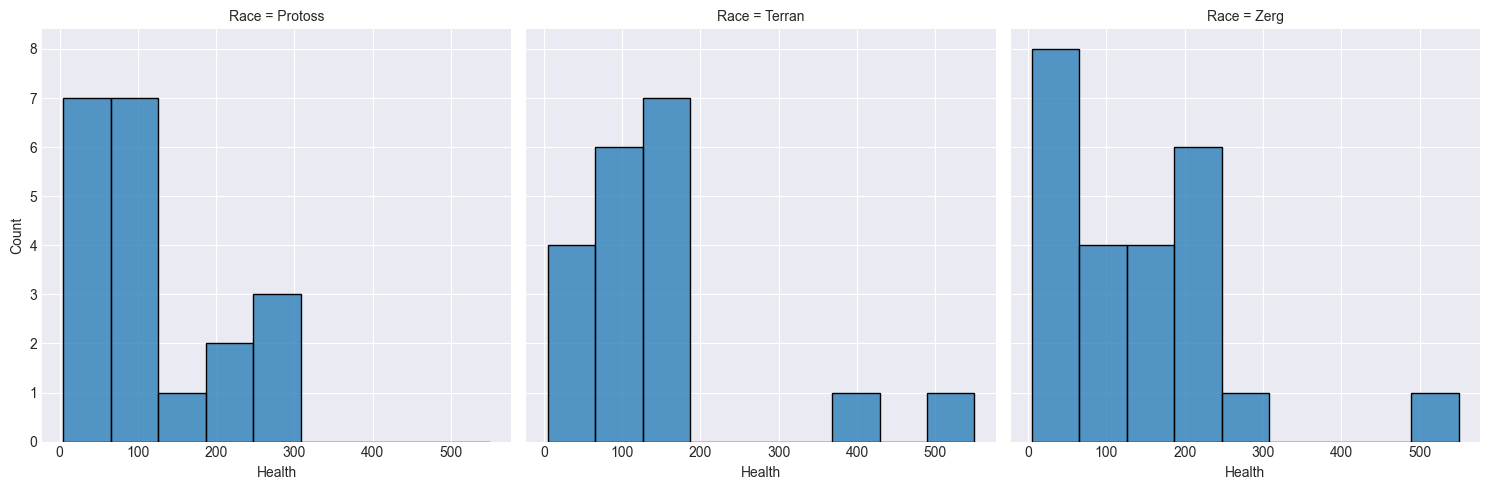

In [61]:
sns.displot(data=df, x="Health",col="Race")

plt.xlabel("Health")
plt.ylabel("Supply")
plt.grid(True)
plt.show()


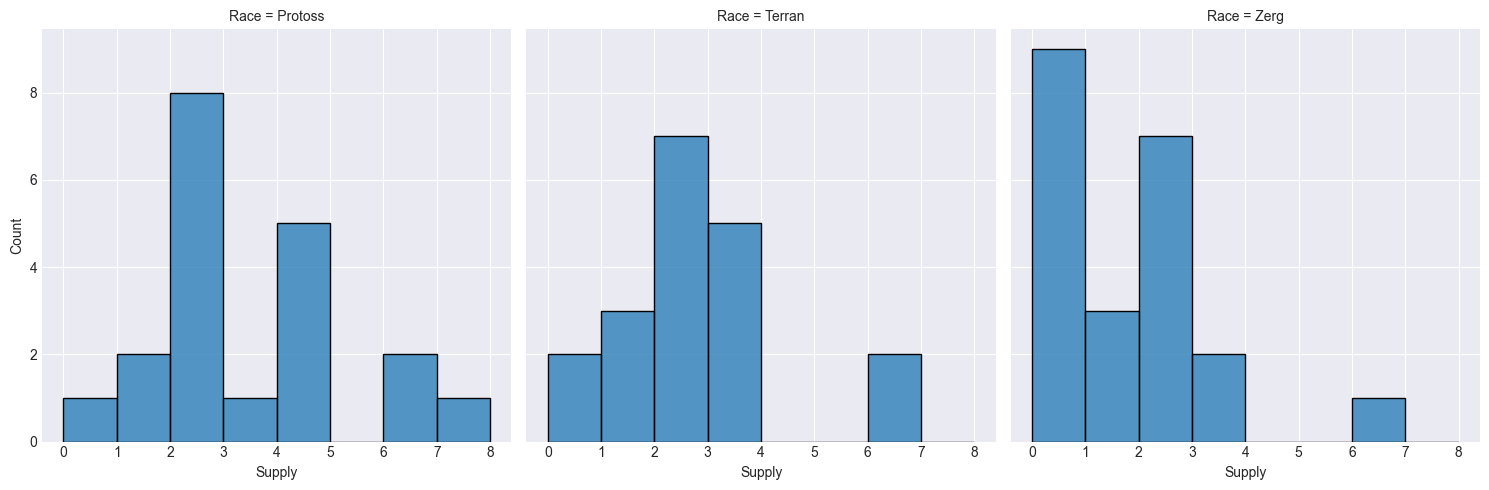

In [62]:
sns.displot(data=df, x="Supply",col="Race")

plt.xlabel("Supply")
plt.grid(True)
plt.show()

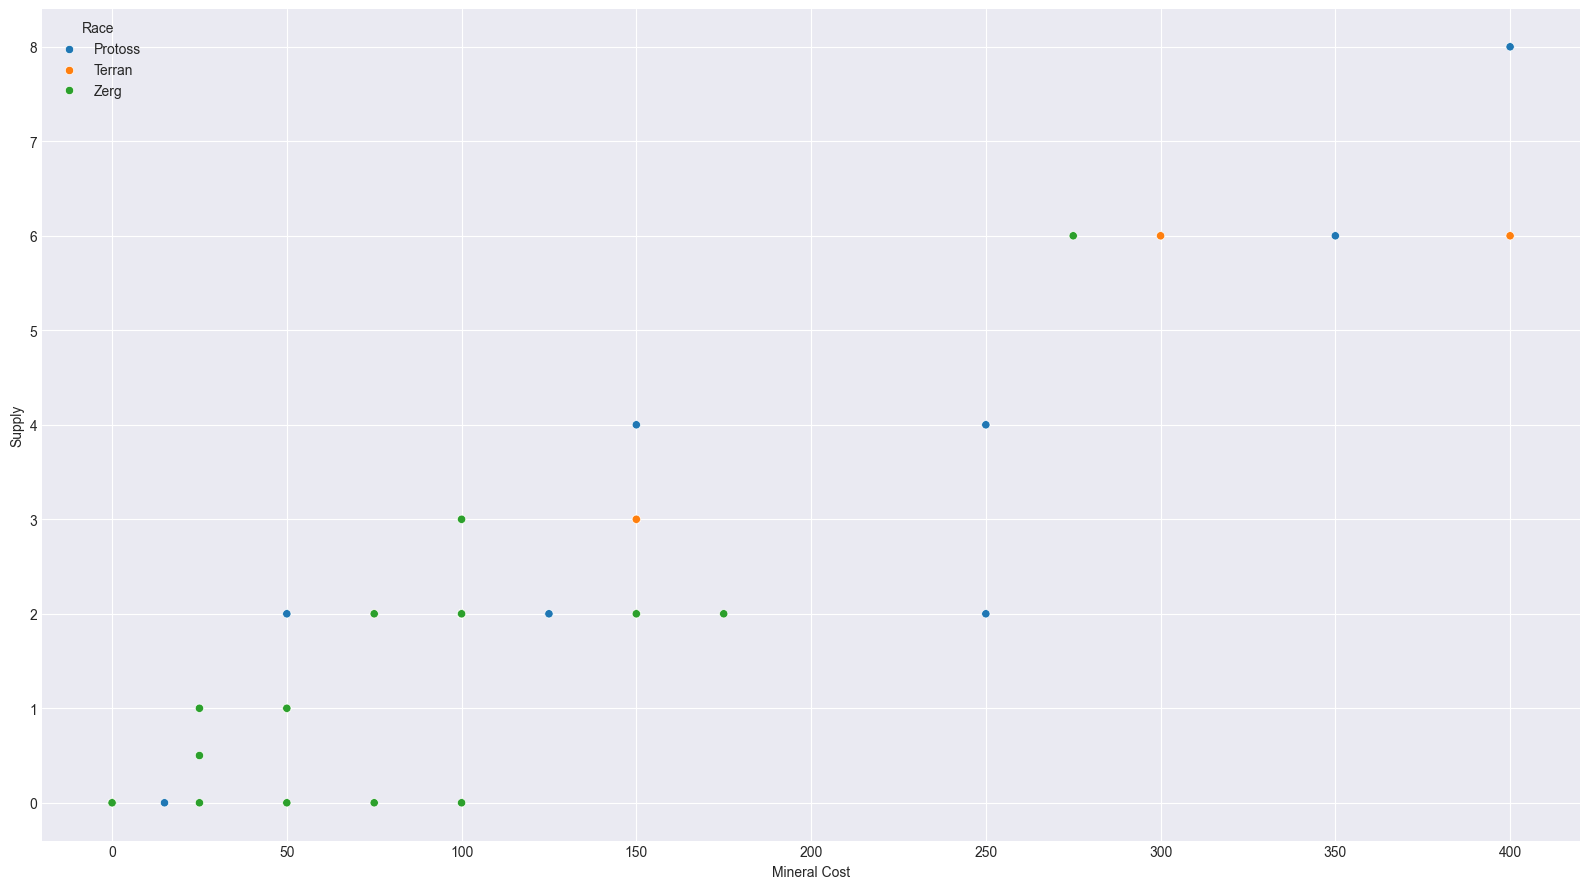

In [63]:
sns.scatterplot(data=df, x="Mineral Cost", y="Supply", hue="Race")
plt.xlabel("Mineral Cost")
plt.ylabel("Supply")
plt.grid(True)
plt.show()


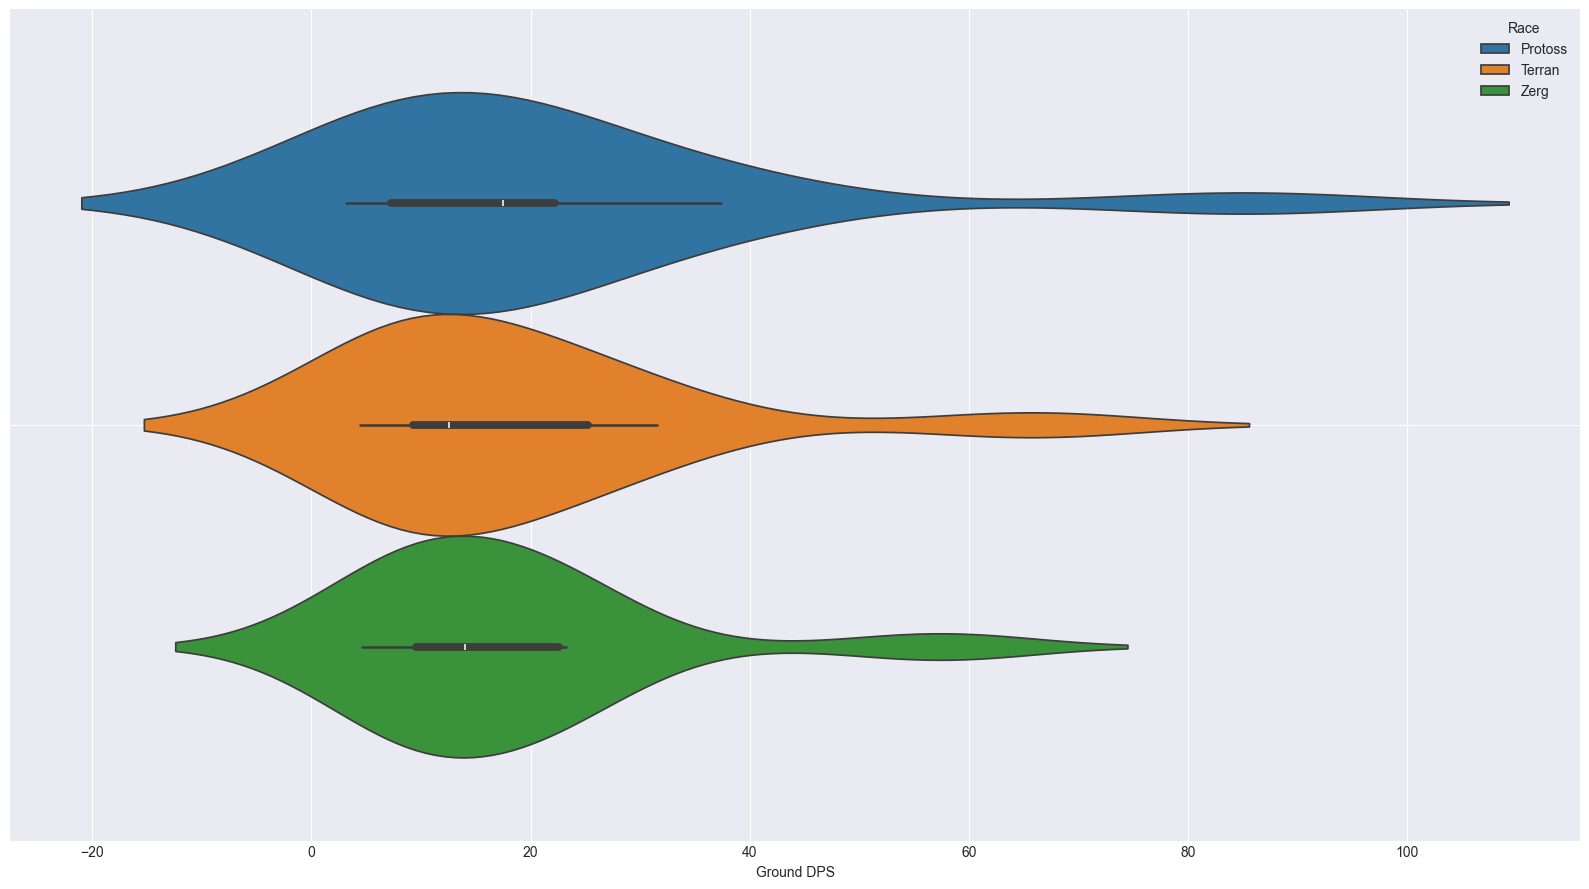

In [64]:
sns.violinplot(data=df, x="Ground DPS", hue="Race")
plt.grid(True)
plt.show()


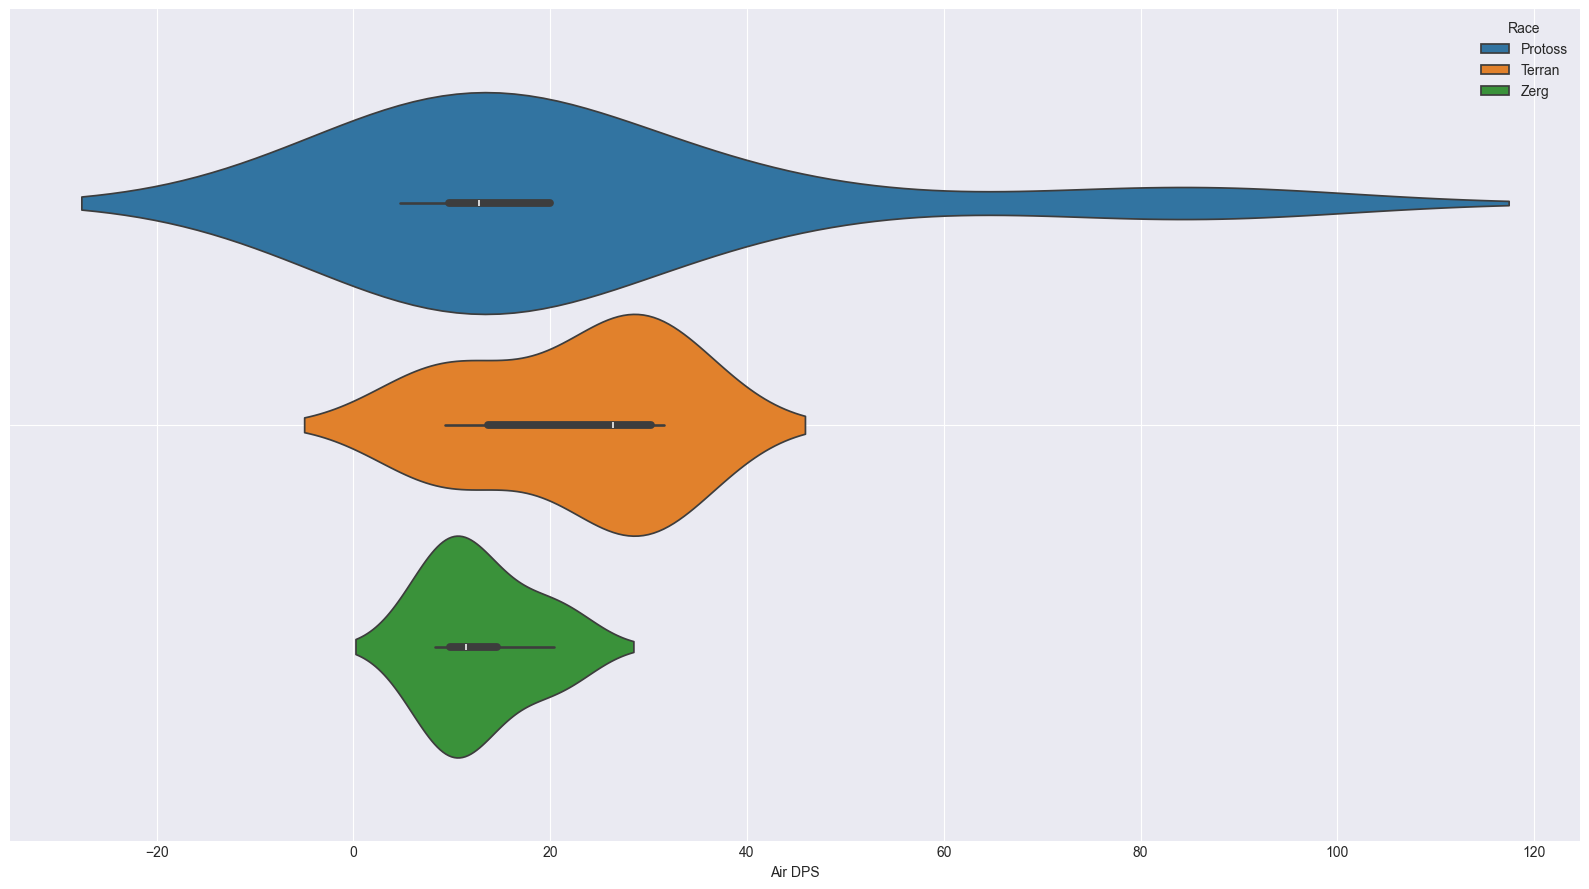

In [65]:
sns.violinplot(data=df, x="Air DPS", hue="Race")
plt.grid(True)
plt.show()


### Sigmoid
$$
\Large{
\sigma = \frac{1}{1+e^{-x}}
}
$$

In [66]:
#python implementation
def sigmoid(x) -> float:
    return 1/(1+ np.exp(-x))

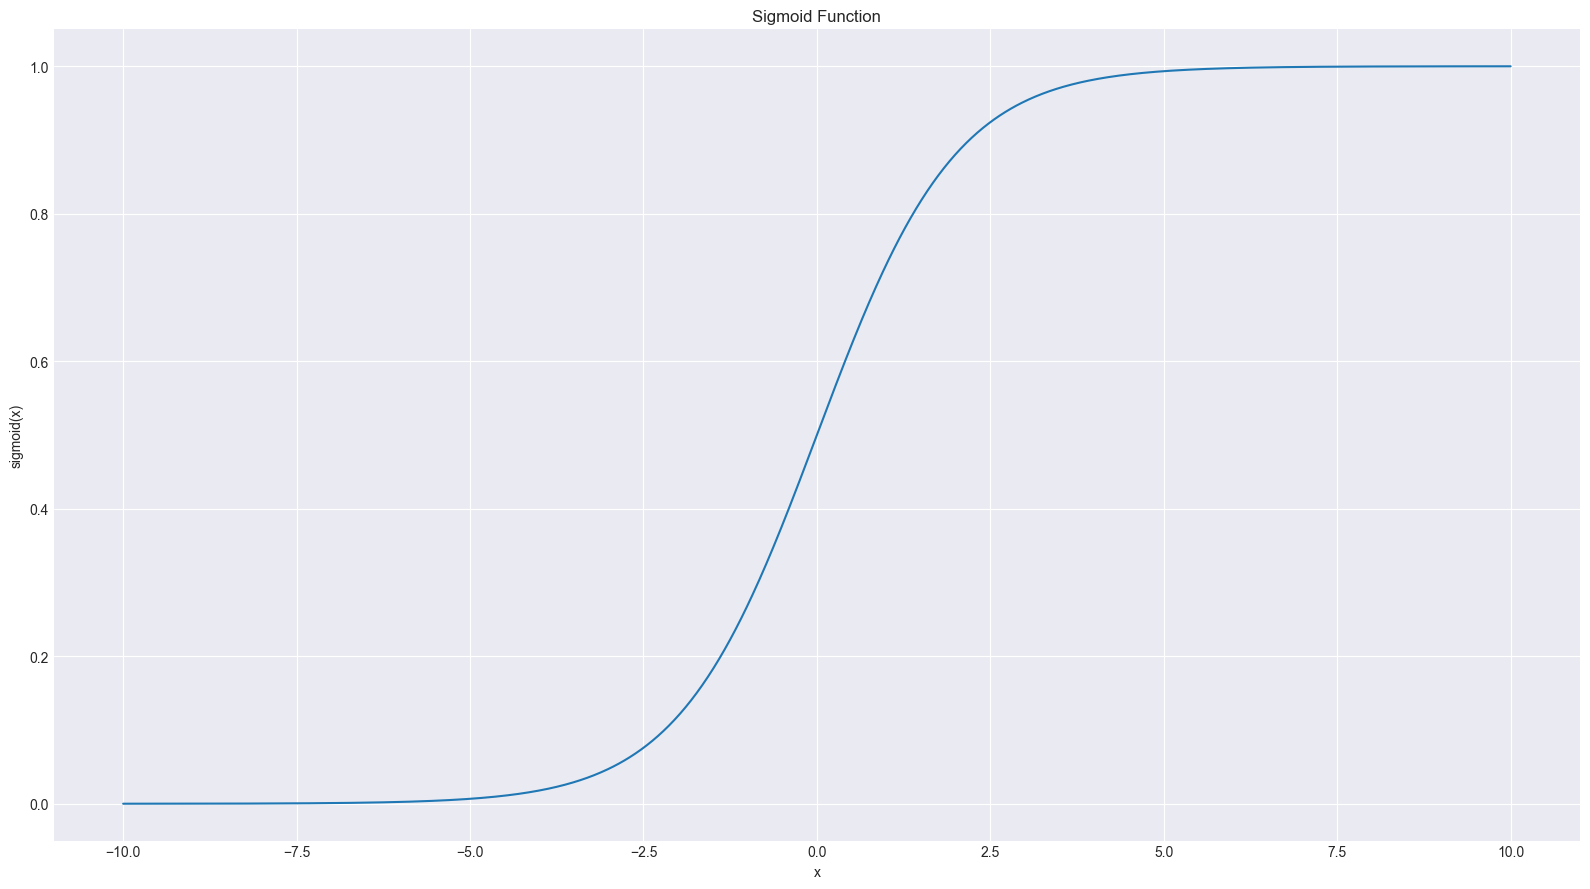

In [67]:
x_values = np.linspace(-10, 10, 1000) 
#[x for x in range(-10, 10, .1)]
y_values = [sigmoid(y) for y in x_values]

plt.plot(x_values, y_values)  # This is the crucial line to add
plt.xlabel("x")
plt.ylabel("sigmoid(x)")
plt.title("Sigmoid Function")
plt.grid(True)  # Optional: Adds a grid to the plot
plt.show()

#### Unit Class

#### All Units

In [68]:
df['dps_score'] = (1/10) * np.sqrt(
    np.pi * (
        (df['Range']**2 * df['Air DPS']) +
        (df['Range']**2 * df['Ground DPS'])
    )
)

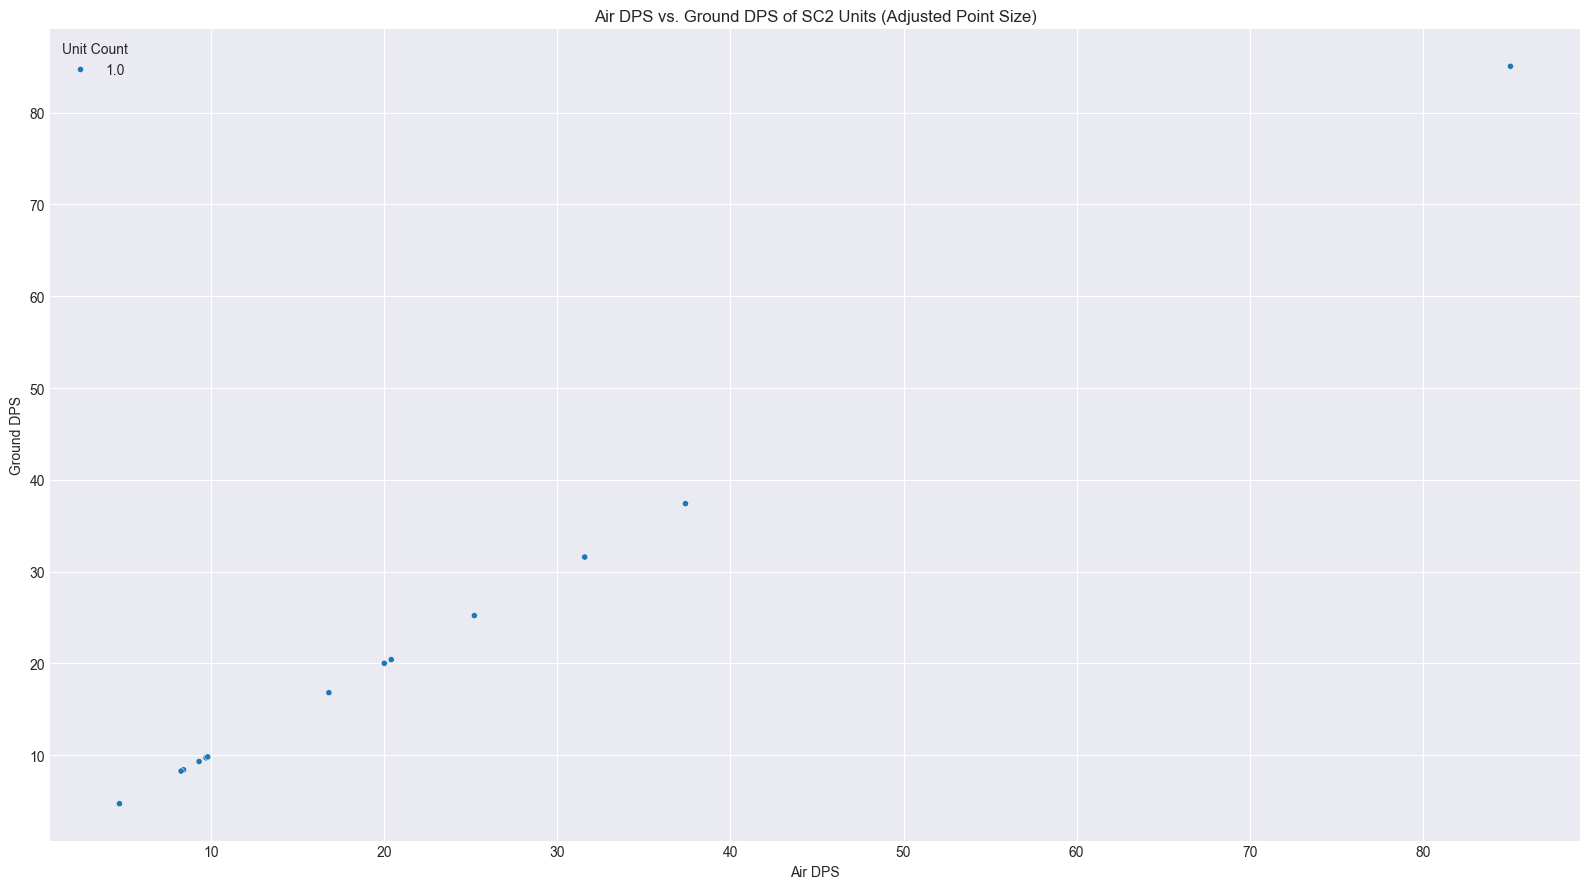

In [69]:
def plot_unit_dps_with_size(df):
    """Plots air DPS vs. ground DPS with unit labels and point size adjustment."""

    counts = df.groupby(['Air DPS', 'Ground DPS']).size().reset_index(name='count')

    df = pd.merge(df, counts, on=['Air DPS', 'Ground DPS'], how='left')

 
    sns.scatterplot(data=df, x="Air DPS", y="Ground DPS", size="count", sizes=(20, 200))

    plt.title("Air DPS vs. Ground DPS of SC2 Units (Adjusted Point Size)")
    plt.xlabel("Air DPS")
    plt.ylabel("Ground DPS")
    plt.grid(True)
    plt.legend(title="Unit Count")
    plt.show()

plot_unit_dps_with_size(df)


#### DPS Scoring

$$
\textrm{DPS Score} = \frac{1}{10}\sqrt{
\pi \left(
\textrm{Air Range}^2 \left( \textrm{AirDPS}\right) +
\textrm{Ground Range}^2 \left(\textrm{GroundDPS}\right)
\right)
}
$$


#### Adjusted DPS:

$$
\textrm{DPS Score} = \frac{1}{10}\sqrt{
\pi \left(
\textrm{Air Range}^2 \left(\frac{\textrm{flying units}}{\textrm{total units}} \textrm{AirDPS}\right) +
\textrm{Ground Range}^2 \left(\frac{\textrm{ground units}}{\textrm{total units}} \textrm{GroundDPS}\right)
\right)
}
$$

In [70]:
df['dps_score'] = (1/10) * np.sqrt(
    np.pi * (
        (df['Range']**2 * df['Air DPS']) +
        (df['Range']**2 * df['Ground DPS'])
    )
)

In [71]:
df.head()

,Race,Name,Supply,Mineral Cost,Vespene Cost,Build_time,Size,Cargo Size,Amour,Health,...,Detector,Biological,Heroic,Massive,Psionic,Light,Mechanical,Armored,Structure,dps_score
0,Protoss,Adept,2.0,100.0,25.0,30,-,2,1,70,...,False,True,False,False,False,True,False,False,False,NaN
1,Protoss,Archon,4.0,NaN,NaN,8.57,-,4,0,10,...,False,False,False,True,True,False,False,False,False,3.362995
2,Protoss,Carrier,6.0,350.0,250.0,64,Large,-,2,300,...,False,False,False,True,False,False,True,True,False,NaN
3,Protoss,Colossus,6.0,300.0,200.0,54,-,8,1,250,...,False,False,False,True,False,False,True,True,False,NaN
4,Protoss,Dark Templar,2.0,125.0,125.0,39,-,2,1,40,...,False,True,False,False,True,True,False,False,False,NaN


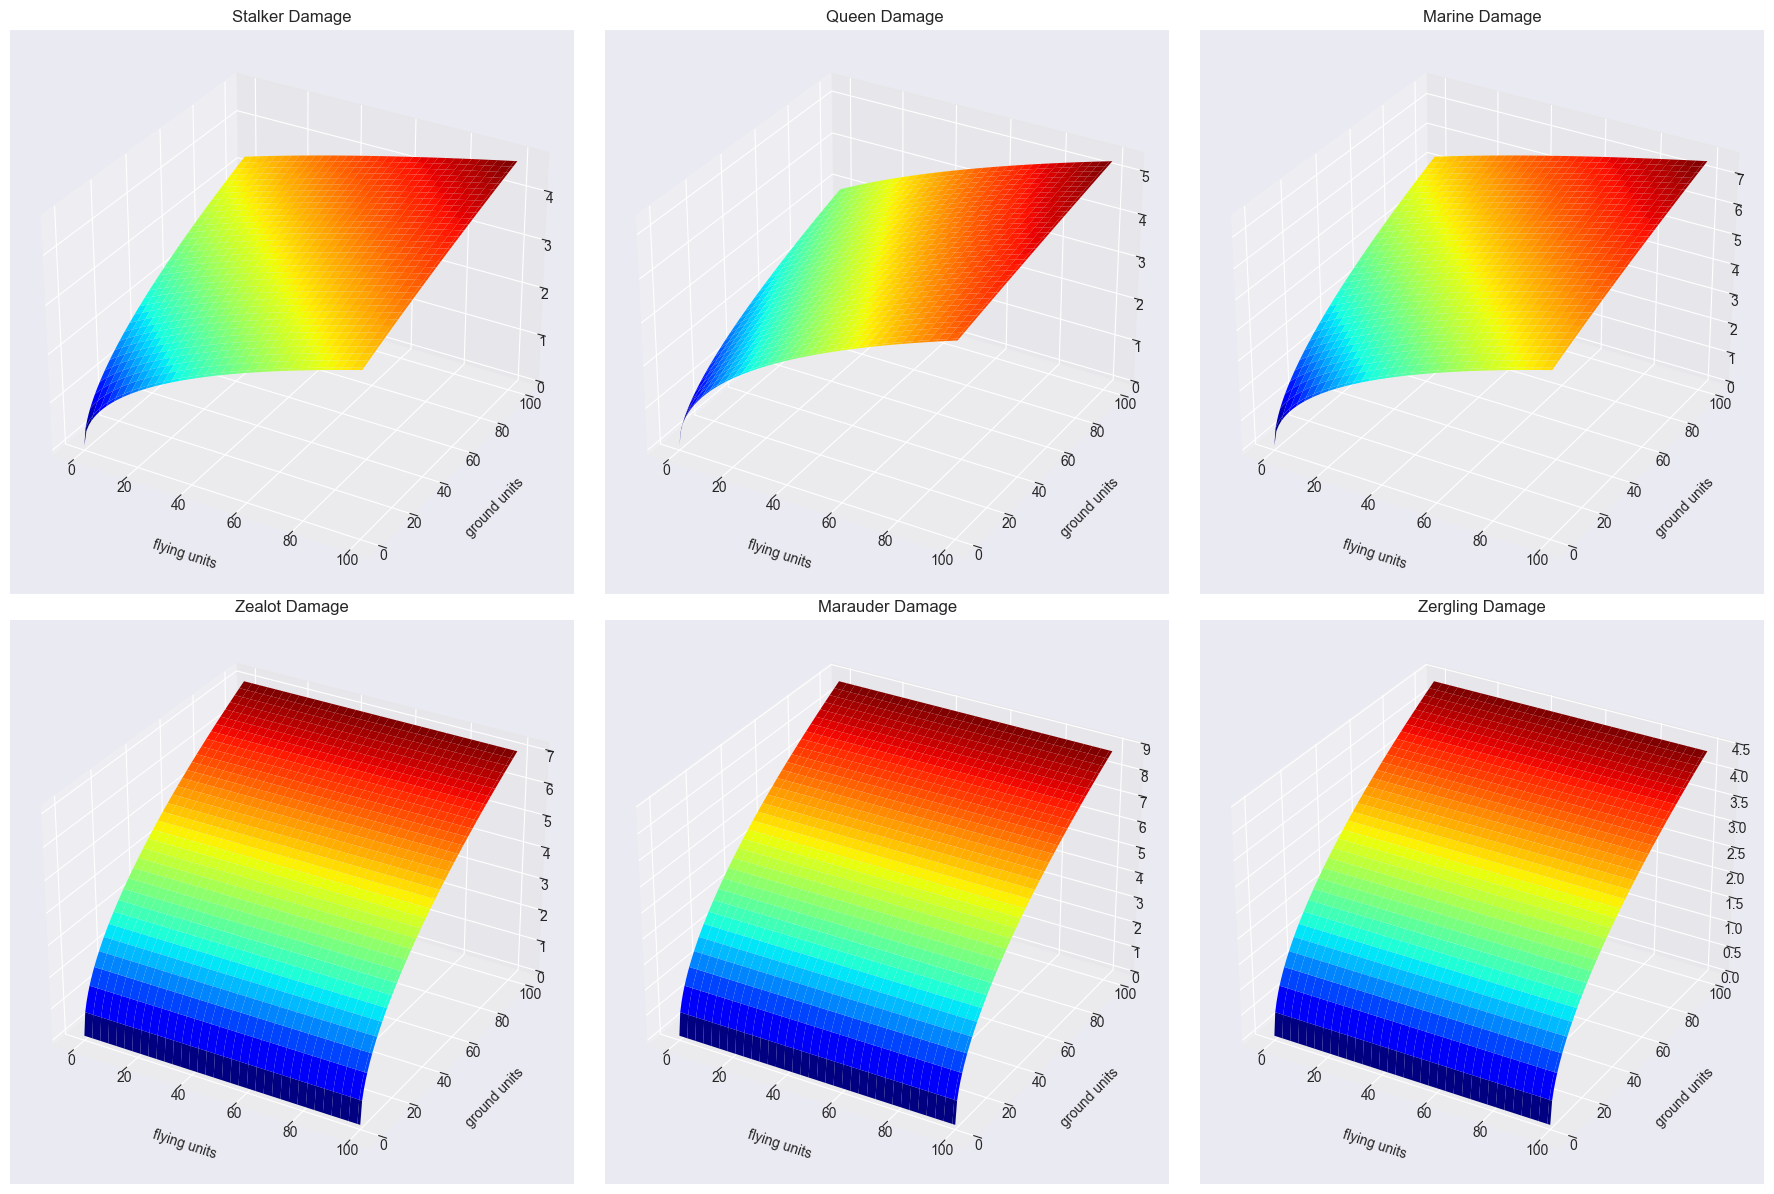

In [72]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12), subplot_kw={'projection': '3d'})

# Stalker
X1 = np.arange(0, 101, 1)
Y1 = 100 - X1
X1, Y1 = np.meshgrid(X1, Y1)
radius = 6
Z1 = np.sqrt((np.pi * radius**2 * (X1/100) * 9.7) + (np.pi * radius**2 * (Y1/100) * 9.7))*0.1
surf1 = axes[0, 0].plot_surface(X1, Y1, Z1, cmap='jet')
axes[0, 0].set_title("Stalker Damage")
axes[0, 0].set_xlabel('flying units')
axes[0, 0].set_ylabel('ground units')
axes[0, 0].tick_params(pad=-7)

# Queen
X2 = np.arange(0, 101, 1)
Y2 = 100 - X2
X2, Y2 = np.meshgrid(X2, Y2)
ground_radius = 5
air_radius = 7
Z2 = np.sqrt((np.pi * air_radius**2 * (X2/100) * 12.6) + (np.pi * ground_radius**2 * (Y2/100) * 11.2))*0.1
surf2 = axes[0, 1].plot_surface(X2, Y2, Z2, cmap='jet')
axes[0, 1].set_title("Queen Damage ")
axes[0, 1].set_xlabel('flying units')
axes[0, 1].set_ylabel('ground units')
axes[0, 1].tick_params(pad=-7)

# Marine
X3 = np.arange(0, 101, 1)
Y3 = 100 - X3
X3, Y3 = np.meshgrid(X3, Y3)
marine_damage_ground = 6
marine_damage_air = 6
Z3 = np.sqrt((np.pi * marine_damage_air**2 * (X3/100)) + (np.pi * marine_damage_ground**2 * (Y3/100)))*0.5
surf3 = axes[0, 2].plot_surface(X3, Y3, Z3, cmap='jet')
axes[0, 2].set_title("Marine Damage")
axes[0, 2].set_xlabel('flying units')
axes[0, 2].set_ylabel('ground units')
axes[0, 2].tick_params(pad=-7)

# Zealot (New Row)
X4 = np.arange(0, 101, 1)
Y4 = 100 - X4
X4, Y4 = np.meshgrid(X4, Y4)
zealot_damage_ground = 8
zealot_damage_air = 0
Z4 = np.sqrt((np.pi * zealot_damage_air**2 * (X4/100)) + (np.pi * zealot_damage_ground**2 * (Y4/100)))*0.5
surf4 = axes[1, 0].plot_surface(X4, Y4, Z4, cmap='jet')
axes[1, 0].set_title("Zealot Damage")
axes[1, 0].set_xlabel('flying units')
axes[1, 0].set_ylabel('ground units')
axes[1, 0].tick_params(pad=-7)

# Marauder (New Row)
X5 = np.arange(0, 101, 1)
Y5 = 100 - X5
X5, Y5 = np.meshgrid(X5, Y5)
marauder_damage_ground = 10  # Example - replace with real value
marauder_damage_air = 0    # Example - replace with real value
Z5 = np.sqrt((np.pi * marauder_damage_air**2 * (X5/100)) + (np.pi * marauder_damage_ground**2 * (Y5/100)))*0.5
surf5 = axes[1, 1].plot_surface(X5, Y5, Z5, cmap='jet')
axes[1, 1].set_title("Marauder Damage")
axes[1, 1].set_xlabel('flying units')
axes[1, 1].set_ylabel('ground units')
axes[1, 1].tick_params(pad=-7)

# Zergling (New Row)
X6 = np.arange(0, 101, 1)
Y6 = 100 - X6
X6, Y6 = np.meshgrid(X6, Y6)
zergling_damage_ground = 5  # Example - replace with real value
zergling_damage_air = 0    # Example - replace with real value
Z6 = np.sqrt((np.pi * zergling_damage_air**2 * (X6/100)) + (np.pi * zergling_damage_ground**2 * (Y6/100)))*0.5
surf6 = axes[1, 2].plot_surface(X6, Y6, Z6, cmap='jet')
axes[1, 2].set_title("Zergling Damage")
axes[1, 2].set_xlabel('flying units')
axes[1, 2].set_ylabel('ground units')
axes[1, 2].tick_params(pad=-7)


plt.tight_layout()
plt.show()

#### Health Scoring

$$
\Large{
\textrm{health score} = \frac{3}{2}-\sigma{\left(\frac{\textrm{remaining health}}{10}\right)}
}
$$

In [73]:
df['health_score'] = 3/2 - sigmoid(df['Health']/10)
df.head()

,Race,Name,Supply,Mineral Cost,Vespene Cost,Build_time,Size,Cargo Size,Amour,Health,...,Biological,Heroic,Massive,Psionic,Light,Mechanical,Armored,Structure,dps_score,health_score
0,Protoss,Adept,2.0,100.0,25.0,30,-,2,1,70,...,True,False,False,False,True,False,False,False,NaN,0.500911
1,Protoss,Archon,4.0,NaN,NaN,8.57,-,4,0,10,...,False,False,True,True,False,False,False,False,3.362995,0.768941
2,Protoss,Carrier,6.0,350.0,250.0,64,Large,-,2,300,...,False,False,True,False,False,True,True,False,NaN,0.500000
3,Protoss,Colossus,6.0,300.0,200.0,54,-,8,1,250,...,False,False,True,False,False,True,True,False,NaN,0.500000
4,Protoss,Dark Templar,2.0,125.0,125.0,39,-,2,1,40,...,True,False,False,True,True,False,False,False,NaN,0.517986


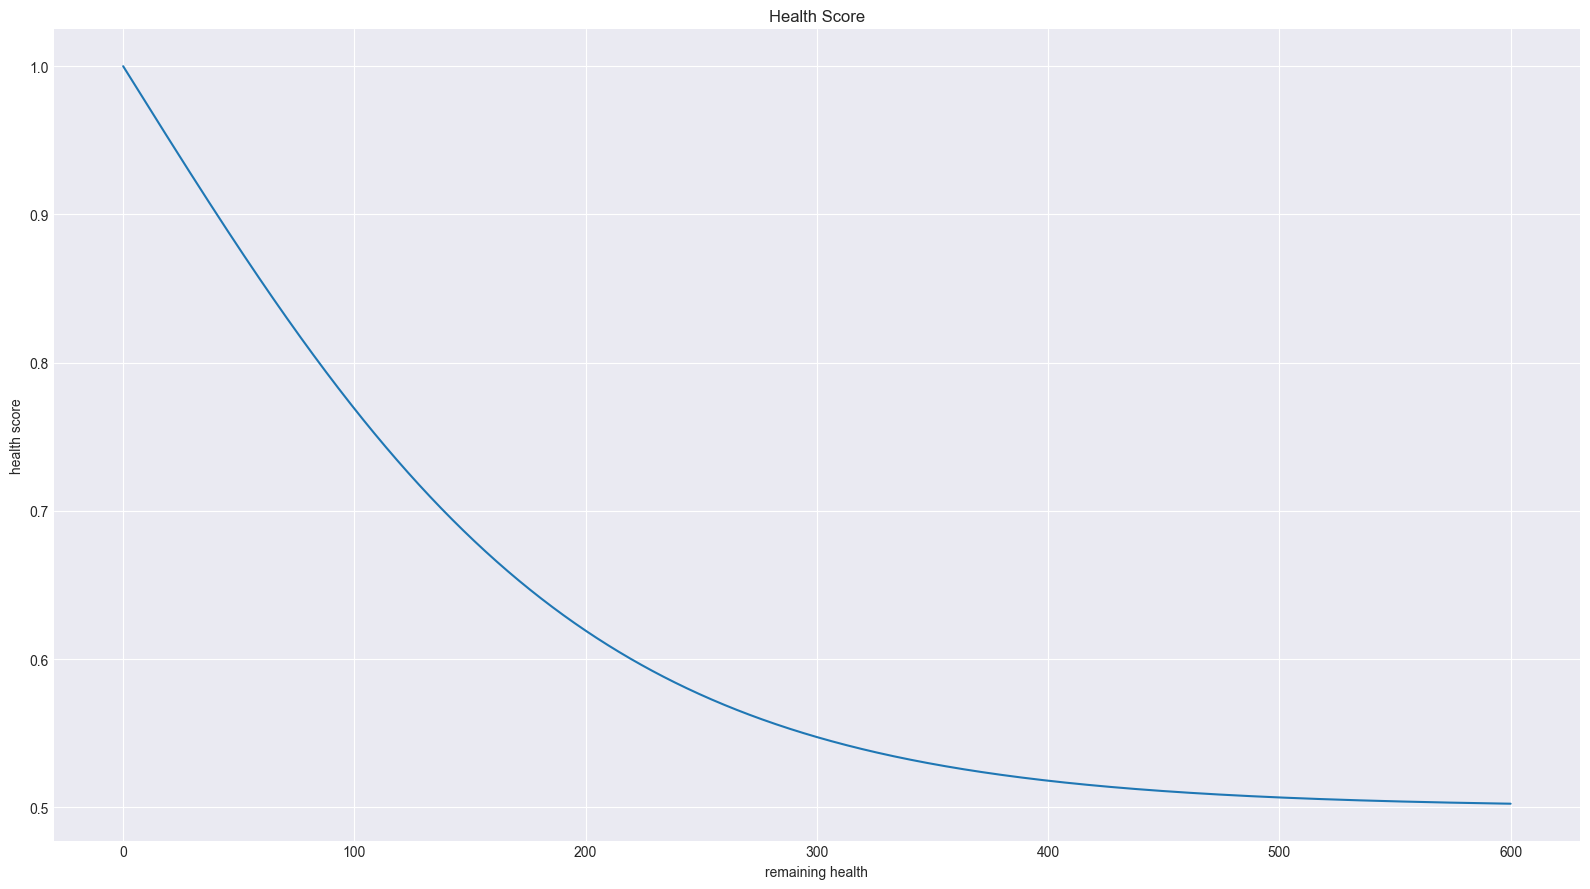

In [74]:
x_values = np.linspace(0, 600, 1000) 
#[x for x in range(-10, 10, .1)]
y_values =[1.5-sigmoid(y/100) for y in x_values]

plt.plot(x_values, y_values)  # This is the crucial line to add
plt.xlabel("remaining health")
plt.ylabel("health score")
plt.title("Health Score")
plt.grid(True)  # Optional: Adds a grid to the plot
plt.show()

#### Cost Scoring

$$
\Large{
\textrm{cost} = \sigma \left(\frac{\sqrt{\textrm{ mineral cost}} + 2.85 \cdot \sqrt{\textrm{ vespene cost}}}{100} \right)
}
$$

In [75]:
df['cost_score'] = sigmoid(
    (np.sqrt(df['Mineral Cost']) + 
            2.85* np.sqrt(df['Vespene Cost'])
            )/10
    )
df.head()

,Race,Name,Supply,Mineral Cost,Vespene Cost,Build_time,Size,Cargo Size,Amour,Health,...,Heroic,Massive,Psionic,Light,Mechanical,Armored,Structure,dps_score,health_score,cost_score
0,Protoss,Adept,2.0,100.0,25.0,30,-,2,1,70,...,False,False,False,True,False,False,False,NaN,0.500911,0.918714
1,Protoss,Archon,4.0,NaN,NaN,8.57,-,4,0,10,...,False,True,True,False,False,False,False,3.362995,0.768941,NaN
2,Protoss,Carrier,6.0,350.0,250.0,64,Large,-,2,300,...,False,True,False,False,True,True,False,NaN,0.500000,0.998303
3,Protoss,Colossus,6.0,300.0,200.0,54,-,8,1,250,...,False,True,False,False,True,True,False,NaN,0.500000,0.996867
4,Protoss,Dark Templar,2.0,125.0,125.0,39,-,2,1,40,...,False,False,True,True,False,False,False,NaN,0.517986,0.986671


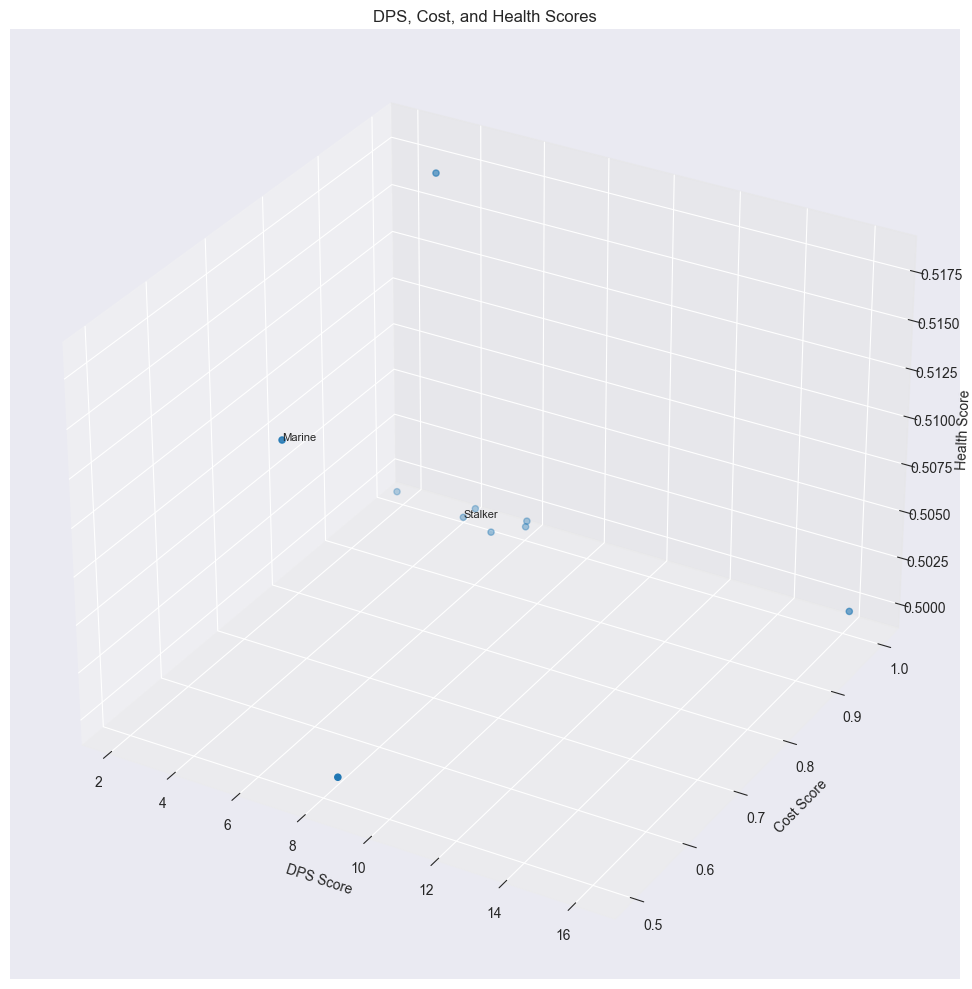

In [76]:
def plot_dps_vs_cost(df):
    """Plots DPS score, cost score, and health score in a 3D scatter plot."""

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Count overlapping points for size adjustment
    counts = df.groupby(['dps_score', 'cost_score', 'health_score']).size().reset_index(name='count')
    df = pd.merge(df, counts, on=['dps_score', 'cost_score', 'health_score'], how='left')

    # Adjust point sizes based on count
    sizes = df['count'] * 20  # You can adjust the multiplier

    ax.scatter(df['dps_score'], df['cost_score'], df['health_score'], s=sizes)

    for index, row in df.iterrows():
        if row['Name'] in ["Zergling", "Stalker", "Marine", "Tempest", "Carrier"]:
            ax.text(row['dps_score'], row['cost_score'], row['health_score'], row['Name'], fontsize=8)

    ax.set_xlabel('DPS Score')
    ax.set_ylabel('Cost Score')
    ax.set_zlabel('Health Score')
    ax.set_title('DPS, Cost, and Health Scores')

    plt.show()


plot_dps_vs_cost(df)

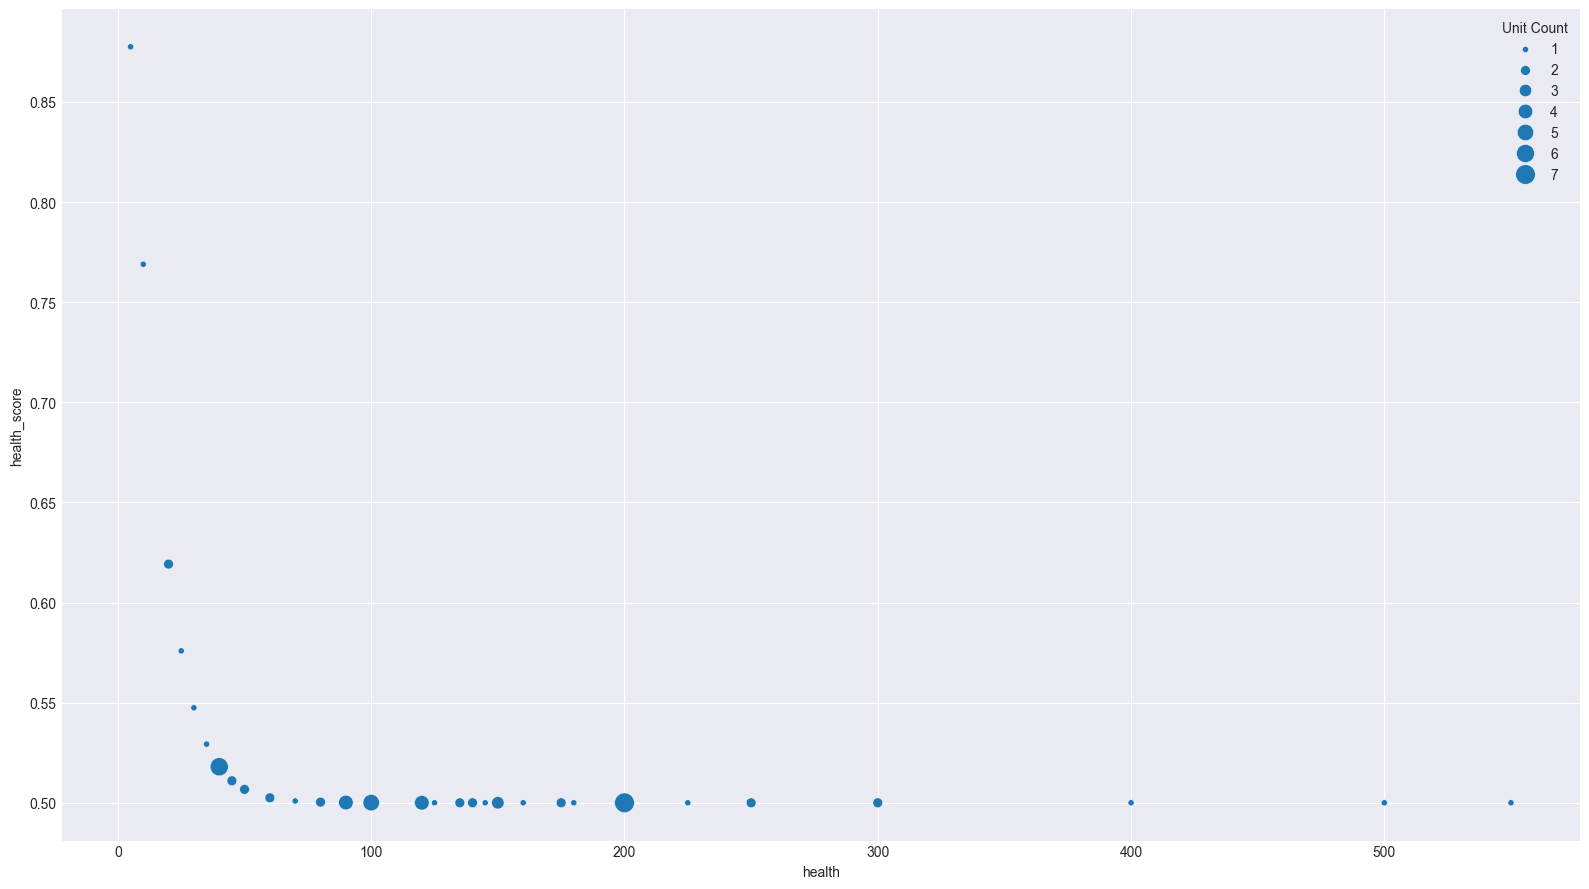

In [77]:
def plot_unit_dps_with_size(df):
    """Plots air DPS vs. ground DPS with unit labels and point size adjustment."""

    # Count the number of units at each (air_dps, ground_dps) coordinate
    counts = df.groupby(['Health', 'health_score']).size().reset_index(name='count')
    
    # Merge the counts back into the original DataFrame
    df = pd.merge(df, counts, on=['Health', 'health_score'], how='left')
            

    # Adjust the size of the points based on the 'count' column
    sns.scatterplot(data=df, x="Health", y="health_score", size="count", sizes=(20, 200))  # Adjust sizes as needed

    plt.xlabel("health")
    plt.ylabel("health_score")
    plt.grid(True)
    plt.legend(title="Unit Count") #add legend for the size
    plt.show()

plot_unit_dps_with_size(df)


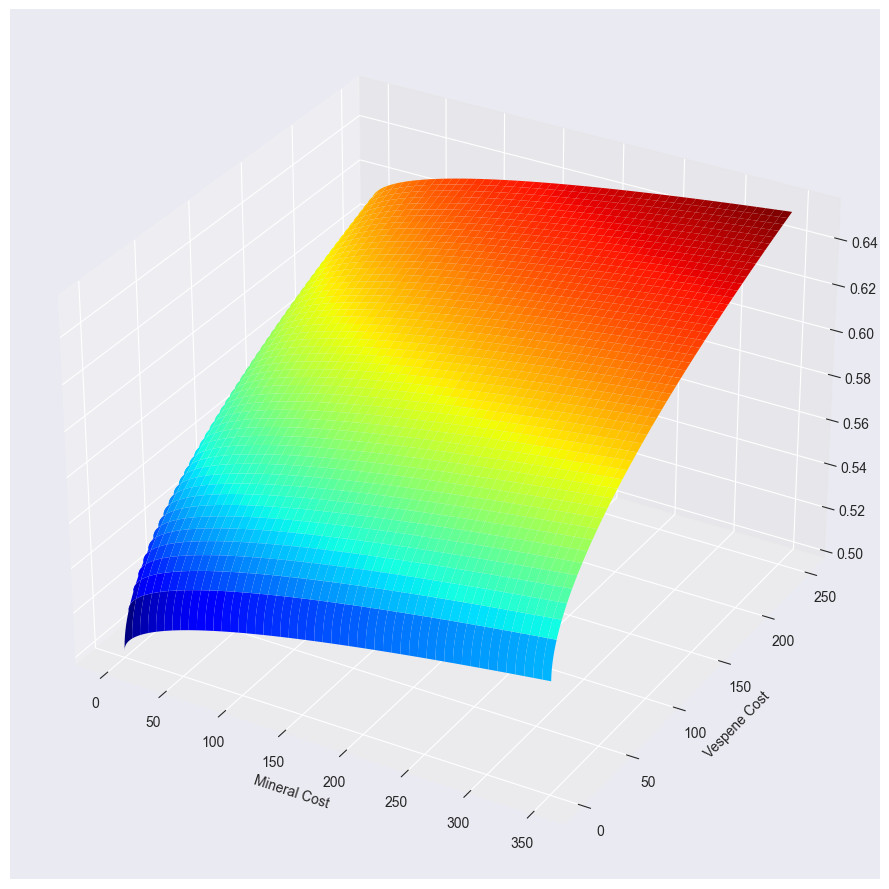

In [78]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create meshgrid data
X = np.arange(0, 350, .1)
Y = np.arange(0, 250, .1)
X, Y = np.meshgrid(X, Y)
Z = sigmoid((np.sqrt(X) + 2.85*np.sqrt(Y))/100)

# Plot the surface
surf = ax.plot_surface(X, Y, Z, cmap='jet')

# Add a color bar
#fig.colorbar(surf, shrink=0.5, aspect=5)

#ax.set_title("TAS without cost")
ax.set_xlabel('Mineral Cost')
ax.set_ylabel('Vespene Cost')
#ax.set_zlabel('Target Allocation Score')

plt.show()

### Target Allocation Score

###### First Idea: 

$$
\Large{
\textrm{TAS} = \sigma\left({\textrm{DPS score} \cdot \textrm{health} \cdot \textrm{cost}}\right)
}
$$


This can't work $\rightarrow$ there are Units with no Mineral or Vespene Cost or no direct Damage Output, which would result in a $\textrm{TAS}$ of $0$ -> but its currently implemented in the bot anyway.

Also should take: 
- Distance to nearest friendly Unit
- Damage Radius
- Energy 

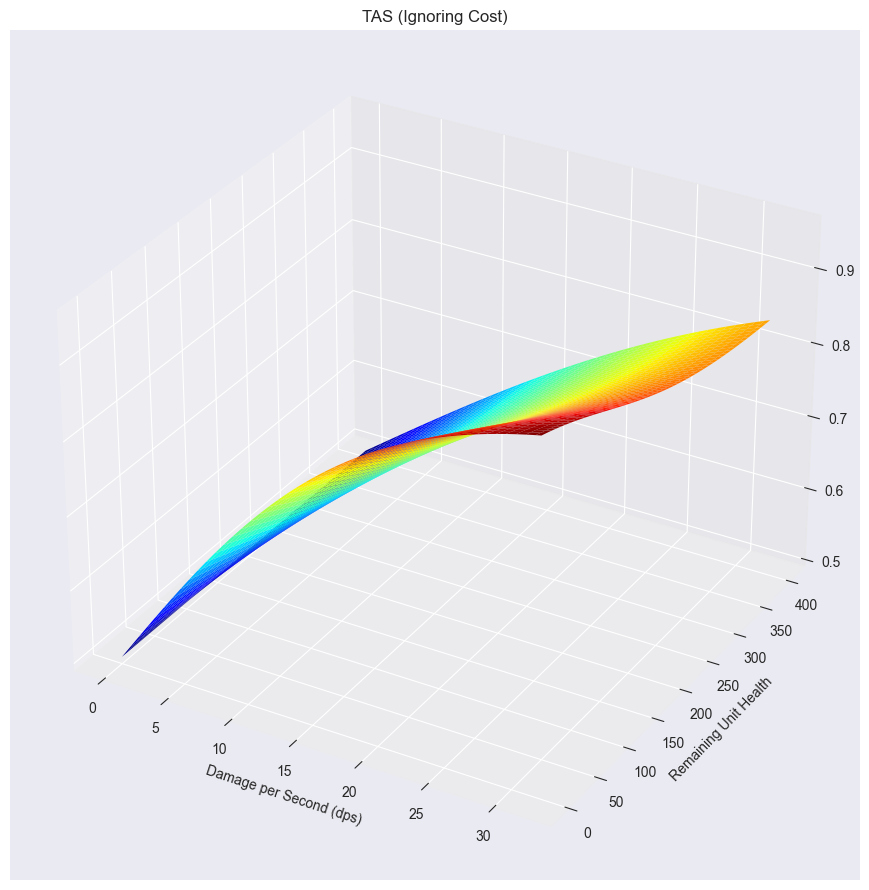

In [79]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create meshgrid data
X = np.arange(0, 32, .1)
Y = np.arange(0, 400, .1)
X, Y = np.meshgrid(X, Y)
Z = sigmoid((X/10) * (1.5-sigmoid(Y/100)))

# Plot the surface
surf = ax.plot_surface(X, Y, Z, cmap='jet')

# Add a color bar
#fig.colorbar(surf, shrink=0.5, aspect=5)

ax.set_title("TAS (Ignoring Cost)")
ax.set_xlabel('Damage per Second (dps)')
ax.set_ylabel('Remaining Unit Health')
#ax.set_zlabel('Target Allocation Score')

plt.show()

In [80]:
def target_allocation_score(unit:Unit) -> float:
    """ calculates the TAS for the unit

    Args:
        unit (Unit): Enemy Unit

    Returns:
        float: TAS (see dev_notebooks/unit_value.ipynb)
    """
    fraction_ground: float = 1/2
    fraction_flying: float = 1/2

    dps_score:float = np.sqrt(np.pi*((unit.air_range**2)*(fraction_flying*unit.air_dps))+((unit.ground_range**2)*(fraction_ground*unit.ground_dps)))/10
    health_score:float = 3/2 -sigmoid(unit.health/10)
    cost_score:float = sigmoid((np.sqrt(unit.mineral_cost) + 2.85 * np.sqrt(unit.vespene_cost))/100)
    return sigmoid(dps_score*health_score*cost_score)

NameError: name 'Unit' is not defined

###### Same Idea as sum: 

$$
\Large{
\textrm{TAS} = \sigma\left({\textrm{DPS score} + \textrm{health} + \textrm{cost}}\right)
}
$$

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create meshgrid data
X = np.arange(0, 32, .1)
Y = np.arange(0, 400, .1)
X, Y = np.meshgrid(X, Y)
Z = sigmoid((X/10) + (1.5-sigmoid(Y/100)))

# Plot the surface
surf = ax.plot_surface(X, Y, Z, cmap='jet')

# Add a color bar
#fig.colorbar(surf, shrink=0.5, aspect=5)

ax.set_title("TAS (Ignoring Cost)")
ax.set_xlabel('Damage per Second (dps)')
ax.set_ylabel('Remaining Unit Health')
#ax.set_zlabel('Target Allocation Score')

plt.show()

Goes to fast to $1$ even when ignoring cost

### Trying make it grow slower

$$
\Large{
\textrm{TAS} = \sigma\left({\frac{-1}{\textrm{DPS score} + {\textrm{health}+{\textrm{cost}}}}}\right)
}
$$

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create meshgrid data
X = np.arange(0, 32, .1)
Y = np.arange(0, 400, .1)
X, Y = np.meshgrid(X, Y)
Z = sigmoid(-1/((X/10) + (1.5-sigmoid(Y/100))))

# Plot the surface
surf = ax.plot_surface(X, Y, Z, cmap='jet')

# Add a color bar
#fig.colorbar(surf, shrink=0.5, aspect=5)

ax.set_title("TAS (Ignoring Cost)")
ax.set_xlabel('Damage per Second (dps)')
ax.set_ylabel('Remaining Unit Health')
#ax.set_zlabel('Target Allocation Score')

plt.show()